# **Import needed libraries**

In [3]:
!pip install numpy
!pip install pandas
!pip install seaborn
!pip install matplotlib
!pip install scikit-learn 
!pip install tensorflow
!pip install setuptools

# import system libs
import os
import itertools

# import data handling tools
import numpy as np
import pandas as pd
import seaborn as sns
sns.set_style('darkgrid')
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report

# import Deep learning Libraries
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam, Adamax
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, GlobalAveragePooling2D, BatchNormalization
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.applications import EfficientNetB1

# ignore the warnings
import warnings
warnings.filterwarnings('ignore')


[notice] A new release of pip is available: 25.0 -> 25.0.1
[notice] To update, run: python.exe -m pip install --upgrade pip



[notice] A new release of pip is available: 25.0 -> 25.0.1
[notice] To update, run: python.exe -m pip install --upgrade pip



[notice] A new release of pip is available: 25.0 -> 25.0.1
[notice] To update, run: python.exe -m pip install --upgrade pip



[notice] A new release of pip is available: 25.0 -> 25.0.1
[notice] To update, run: python.exe -m pip install --upgrade pip



[notice] A new release of pip is available: 25.0 -> 25.0.1
[notice] To update, run: python.exe -m pip install --upgrade pip



[notice] A new release of pip is available: 25.0 -> 25.0.1
[notice] To update, run: python.exe -m pip install --upgrade pip



[notice] A new release of pip is available: 25.0 -> 25.0.1
[notice] To update, run: python.exe -m pip install --upgrade pip


# **Loading the dataset**

> Read the training dataset into the dataframe

In [4]:
# loading the dataset
def loading_the_data(data_dir):
    # Generate data paths with labels
    filepaths = []
    labels = []

    # Get folder names
    folds = os.listdir(data_dir)

    for fold in folds:
        foldpath = os.path.join(data_dir, fold)
        filelist = os.listdir(foldpath)
        for file in filelist:
            fpath = os.path.join(foldpath, file)
            
            filepaths.append(fpath)
            labels.append(fold)

    # Concatenate data paths with labels into one DataFrame
    Fseries = pd.Series(filepaths, name='filepaths')
    Lseries = pd.Series(labels, name='labels')

    df = pd.concat([Fseries, Lseries], axis=1)
    
    return df


# change label names to its original names
def change_label_names(df, column_name):
    index = {'lung_aca': 'Lung_adenocarcinoma', 'lung_n': 'Lung_benign_tissue', 'lung_scc': 'Lung squamous_cell_carcinoma'}


    df[column_name] = df[column_name].replace(index)

In [5]:
# loading the data
data_dir =   "D:\Project1\dataset\lung_image_sets"
df = loading_the_data(data_dir)

change_label_names(df, 'labels')

df

filepaths  \
0      D:\Project1\dataset\lung_image_sets\lung_aca\l...   
1      D:\Project1\dataset\lung_image_sets\lung_aca\l...   
2      D:\Project1\dataset\lung_image_sets\lung_aca\l...   
3      D:\Project1\dataset\lung_image_sets\lung_aca\l...   
4      D:\Project1\dataset\lung_image_sets\lung_aca\l...   
...                                                  ...   
14995  D:\Project1\dataset\lung_image_sets\lung_scc\l...   
14996  D:\Project1\dataset\lung_image_sets\lung_scc\l...   
14997  D:\Project1\dataset\lung_image_sets\lung_scc\l...   
14998  D:\Project1\dataset\lung_image_sets\lung_scc\l...   
14999  D:\Project1\dataset\lung_image_sets\lung_scc\l...   

                             labels  
0               Lung_adenocarcinoma  
1               Lung_adenocarcinoma  
2               Lung_adenocarcinoma  
3               Lung_adenocarcinoma  
4               Lung_adenocarcinoma  
...                             ...  
14995  Lung squamous_cell_carcinoma  
14996  Lung squamous_cell_carcinoma  
14997  Lung squamous_cell_carcinoma  
14998  Lung squamous_cell_carcinoma  
14999  Lung squamous_cell_carcinoma  

[15000 rows x 2 columns]

# **Data preprocessing**

first we will check if the training data is balanced or not

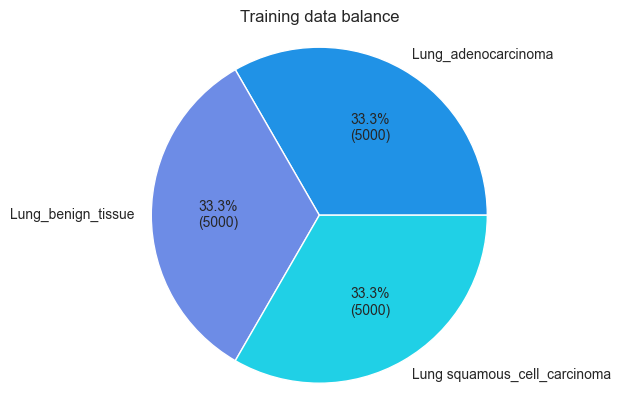

In [6]:
data_balance = df.labels.value_counts()


def custom_autopct(pct):
    total = sum(data_balance)
    val = int(round(pct*total/100.0))
    return "{:.1f}%\n({:d})".format(pct, val)


# pie chart for data balance
plt.pie(data_balance, labels = data_balance.index, autopct=custom_autopct, colors = ["#2092E6","#6D8CE6","#20D0E6"])
plt.title("Training data balance")
plt.axis("equal")
plt.show()

It is balanced, now we will split our data to train, val and test set

In [7]:
# data --> 80% train data && 20% (test, val)
train_df, ts_df = train_test_split(df, train_size = 0.8, shuffle = True, random_state = 42)

# test data --> 10% train data && 10% (test, val)
valid_df, test_df = train_test_split(ts_df, train_size = 0.5, shuffle = True, random_state = 42)

**Create image data generator**

in this step we will convert the whoole data to numpy arrays

In [8]:
# crobed image size
batch_size = 32
img_size = (224, 224)

tr_gen = ImageDataGenerator(rescale=1. / 255)
ts_gen = ImageDataGenerator(rescale=1. / 255)

train_gen = tr_gen.flow_from_dataframe( train_df, x_col= 'filepaths', y_col= 'labels', target_size= img_size, class_mode= 'categorical',
                                    color_mode= 'rgb', shuffle= True, batch_size= batch_size)

valid_gen = ts_gen.flow_from_dataframe( valid_df, x_col= 'filepaths', y_col= 'labels', target_size= img_size, class_mode= 'categorical',
                                    color_mode= 'rgb', shuffle= True, batch_size= batch_size)

test_gen = ts_gen.flow_from_dataframe( test_df, x_col= 'filepaths', y_col= 'labels', target_size= img_size, class_mode= 'categorical',
                                    color_mode= 'rgb', shuffle= False, batch_size= batch_size)

Found 12000 validated image filenames belonging to 3 classes.
Found 1500 validated image filenames belonging to 3 classes.
Found 1500 validated image filenames belonging to 3 classes.


**Display sample from train data**

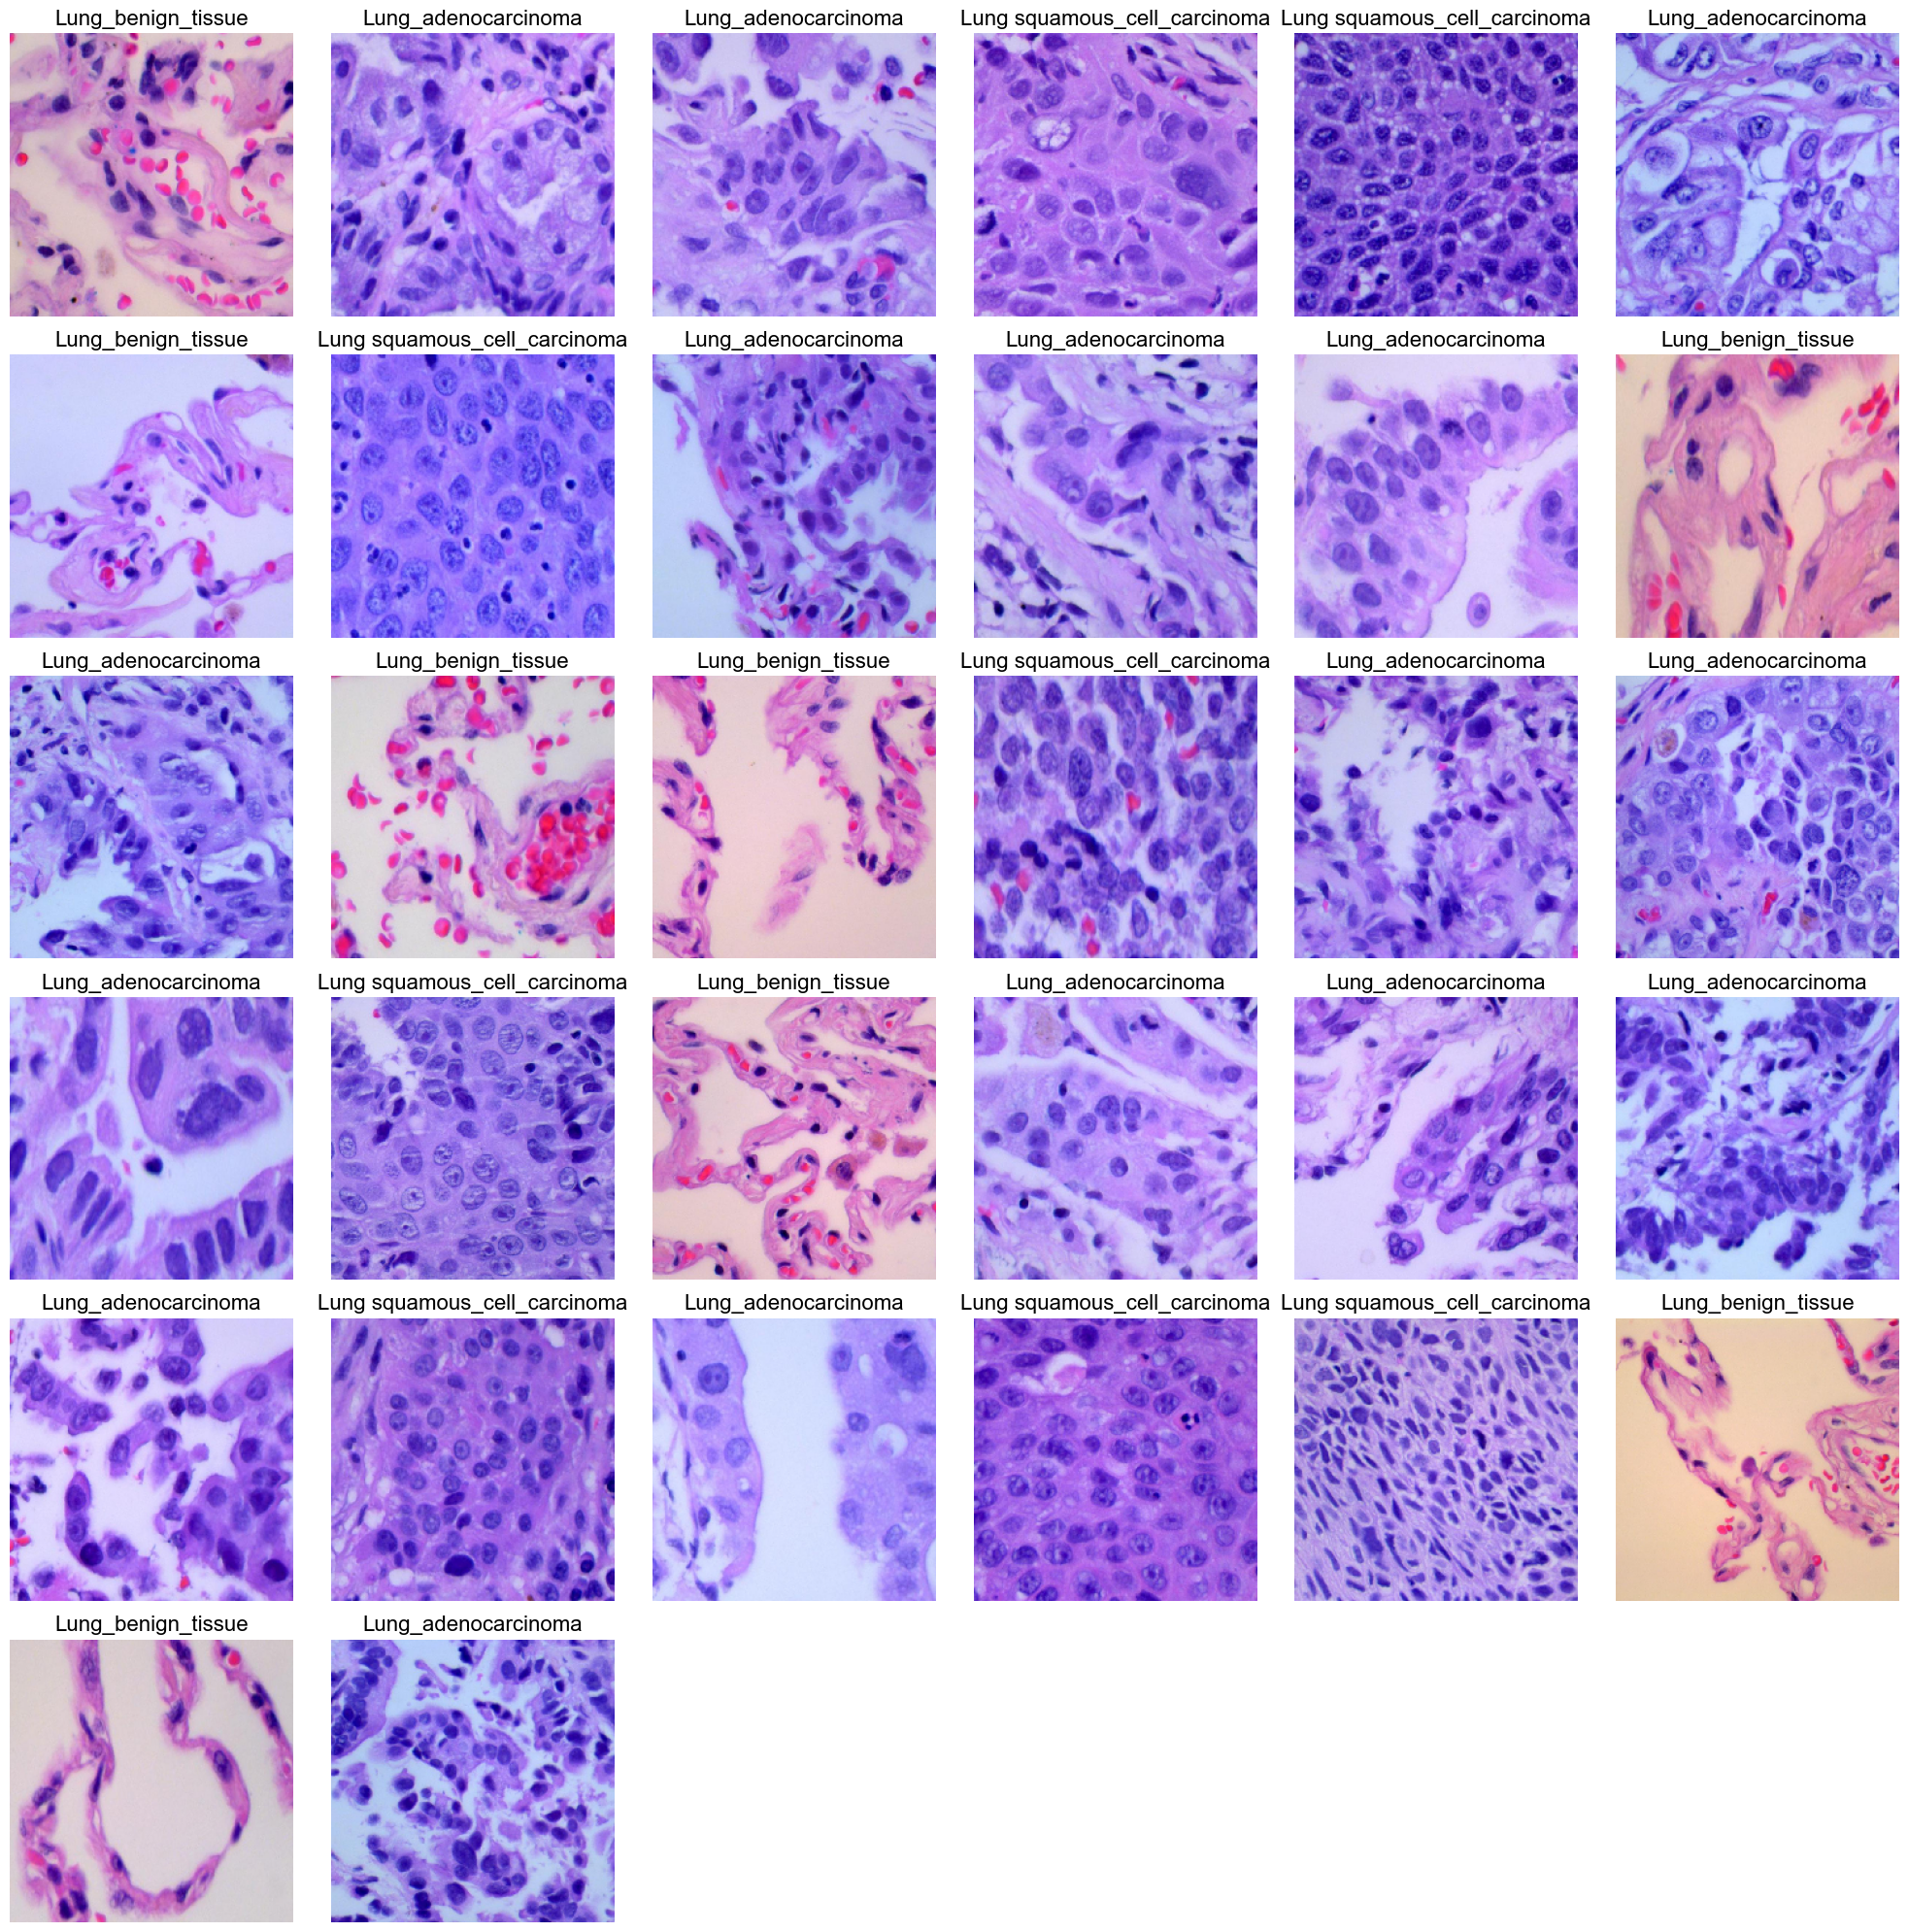

In [9]:
g_dict = train_gen.class_indices      # defines dictionary {'class': index}
classes = list(g_dict.keys())       # defines list of dictionary's kays (classes), classes names : string
images, labels = next(train_gen)      # get a batch size samples from the generator

# ploting the patch size samples
plt.figure(figsize= (20, 20))

for i in range(batch_size):
    plt.subplot(6, 6, i + 1)
    image = images[i]
    plt.imshow(image)
    index = np.argmax(labels[i])  # get image index
    class_name = classes[index]   # get class of image
    plt.title(class_name, color= 'black', fontsize= 16)
    plt.axis('off')
plt.tight_layout()
plt.show()

# **Create needed functions**

In [10]:
# Displaying the model performance
def model_performance(history, Epochs):
    # Define needed variables
    tr_acc = history.history['accuracy']
    tr_loss = history.history['loss']
    val_acc = history.history['val_accuracy']
    val_loss = history.history['val_loss']
    
    Epochs = [i+1 for i in range(len(tr_acc))]
    
    # Plot training history
    plt.figure(figsize= (20, 8))
    plt.style.use('fivethirtyeight')
    
    plt.subplot(1, 2, 1)
    plt.plot(Epochs, tr_loss, 'r', label= 'Training loss')
    plt.plot(Epochs, val_loss, 'g', label= 'Validation loss')
    plt.title('Training and Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    
    plt.subplot(1, 2, 2)
    plt.plot(Epochs, tr_acc, 'r', label= 'Training Accuracy')
    plt.plot(Epochs, val_acc, 'g', label= 'Validation Accuracy')
    plt.title('Training and Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    
    plt.tight_layout
    plt.show()
    

# Evaluate the model
def model_evaluation(model):
    train_score = model.evaluate(train_gen, verbose= 1)
    valid_score = model.evaluate(valid_gen, verbose= 1)
    test_score = model.evaluate(test_gen, verbose= 1)
    
    print("Train Loss: ", train_score[0])
    print("Train Accuracy: ", train_score[1])
    print('-' * 20)
    print("Validation Loss: ", valid_score[0])
    print("Validation Accuracy: ", valid_score[1])
    print('-' * 20)
    print("Test Loss: ", test_score[0])
    print("Test Accuracy: ", test_score[1])
    

# Get Predictions
def get_pred(model, test_gen):
    
    preds = model.predict(test_gen)
    y_pred = np.argmax(preds, axis = 1)
    
    return y_pred


# Confusion Matrix
def plot_confusion_matrix(test_gen, y_pred):
    
    g_dict = test_gen.class_indices
    classes = list(g_dict.keys())
    
    # Display the confusion matrix
    cm = confusion_matrix(test_gen.classes, y_pred)

    plt.figure(figsize= (10, 10))
    plt.imshow(cm, interpolation= 'nearest', cmap= plt.cm.Blues)
    plt.title('Confusion Matrix')
    plt.colorbar()
    
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation= 45)
    plt.yticks(tick_marks, classes)
    
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j], horizontalalignment= 'center', color= 'white' if cm[i, j] > thresh else 'black')
    
    
    plt.tight_layout()
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    
    plt.show()
    
    
# Defining a convolutional NN block for a sequential CNN model
def conv_block(filters, act='relu'):
    
    block = Sequential()
    block.add(Conv2D(filters, 3, activation=act, padding='same'))
    block.add(Conv2D(filters, 3, activation=act, padding='same'))
    block.add(BatchNormalization())
    block.add(MaxPooling2D())
    
    return block


# Defining a dense NN block for a sequential CNN model
def dense_block(units, dropout_rate, act='relu'):
    
    block = Sequential()
    block.add(Dense(units, activation=act))
    block.add(BatchNormalization())
    block.add(Dropout(dropout_rate))
    
    return block

# **Model Structure**

# **CNN model**

In [11]:
# create Model structure
img_size = (224, 224)
channels = 3
img_shape = (img_size[0], img_size[1], channels)

class_counts = len(list(train_gen.class_indices.keys()))     # to define number of classes in dense layer

In [12]:
# Model architecture
cnn_model = Sequential()

# first conv block
cnn_model.add(Conv2D(filters=16, kernel_size=(3,3), padding="same", activation="relu", input_shape= img_shape))
cnn_model.add(BatchNormalization())
cnn_model.add(MaxPooling2D())

# second conv block
cnn_model.add(conv_block(32))

# third conv block
cnn_model.add(conv_block(64))

# fourth conv bolck
cnn_model.add(conv_block(128))

# fifth conv block
cnn_model.add(conv_block(256))

# flatten layer
cnn_model.add(Flatten())

# first dense block
cnn_model.add(dense_block(128, 0.5))

# second dense block
cnn_model.add(dense_block(64, 0.3))

# third dense block
cnn_model.add(dense_block(32, 0.2))

# output layer
cnn_model.add(Dense(class_counts, activation = "softmax"))

In [13]:
cnn_model.compile(Adamax(learning_rate= 0.001), loss= 'categorical_crossentropy', metrics= ['accuracy'])

cnn_model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 224, 224, 16)   │           448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 224, 224, 16)   │            64 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 112, 112, 16)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ sequential_1 (Sequential)       │ (None, 56, 56, 32)     │        14,016 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ sequential_2 (Sequential)       │ (None, 28, 28, 64)     │        55,680 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ sequential_3 (Sequential)       │ (None, 14, 14, 128)    │       221,952 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ sequential_4 (Sequential)       │ (None, 7, 7, 256)      │       886,272 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 12544)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ sequential_5 (Sequential)       │ (None, 128)            │     1,606,272 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ sequential_6 (Sequential)       │ (None, 64)             │         8,512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ sequential_7 (Sequential)       │ (None, 32)             │         2,208 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 3)              │            99 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,795,523 (10.66 MB)

 Trainable params: 2,794,083 (10.66 MB)

 Non-trainable params: 1,440 (5.62 KB)

In [14]:
# train the model
epochs = 8  # number of all epochs in training

history = cnn_model.fit(train_gen, epochs= epochs, verbose= 1, validation_data= valid_gen, shuffle= False)

Epoch 1/8
375/375 ━━━━━━━━━━━━━━━━━━━━ 324s 846ms/step - accuracy: 0.7886 - loss: 0.5495 - val_accuracy: 0.3340 - val_loss: 4.8225
Epoch 2/8
375/375 ━━━━━━━━━━━━━━━━━━━━ 312s 833ms/step - accuracy: 0.9284 - loss: 0.2204 - val_accuracy: 0.9500 - val_loss: 0.1254
Epoch 3/8
375/375 ━━━━━━━━━━━━━━━━━━━━ 326s 869ms/step - accuracy: 0.9363 - loss: 0.1755 - val_accuracy: 0.9473 - val_loss: 0.1386
Epoch 4/8
375/375 ━━━━━━━━━━━━━━━━━━━━ 343s 914ms/step - accuracy: 0.9487 - loss: 0.1424 - val_accuracy: 0.8960 - val_loss: 0.2821
Epoch 5/8
375/375 ━━━━━━━━━━━━━━━━━━━━ 361s 963ms/step - accuracy: 0.9547 - loss: 0.1288 - val_accuracy: 0.9527 - val_loss: 0.1212
Epoch 6/8
375/375 ━━━━━━━━━━━━━━━━━━━━ 362s 965ms/step - accuracy: 0.9642 - loss: 0.1009 - val_accuracy: 0.9367 - val_loss: 0.1796
Epoch 7/8
375/375 ━━━━━━━━━━━━━━━━━━━━ 362s 964ms/step - accuracy: 0.9682 - loss: 0.0921 - val_accuracy: 0.9573 - val_loss: 0.1287
Epoch 8/8
375/375 ━━━━━━━━━━━━━━━━━━━━ 361s 961ms/step - accuracy: 0.9748 - loss: 0

**Display model performance**

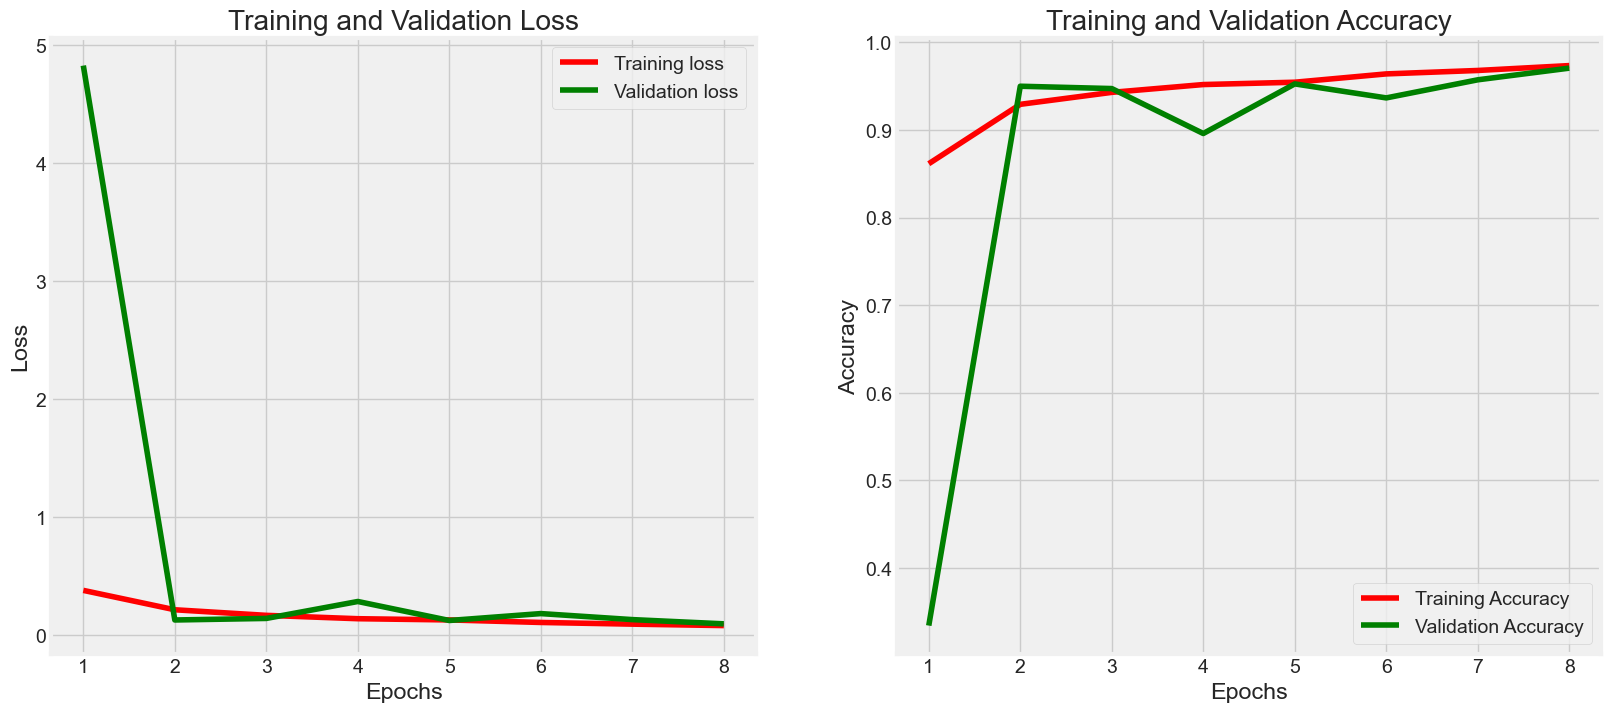

In [15]:
# Display model performance
model_performance(history, epochs)

**Evaluate the model**

In [16]:
# Model evaluation
model_evaluation(cnn_model)

375/375 ━━━━━━━━━━━━━━━━━━━━ 111s 295ms/step - accuracy: 0.9867 - loss: 0.0367
47/47 ━━━━━━━━━━━━━━━━━━━━ 14s 290ms/step - accuracy: 0.9663 - loss: 0.1042
47/47 ━━━━━━━━━━━━━━━━━━━━ 16s 332ms/step - accuracy: 0.9729 - loss: 0.0746
Train Loss:  0.043304234743118286
Train Accuracy:  0.9834166765213013
--------------------
Validation Loss:  0.09277620166540146
Validation Accuracy:  0.9706666469573975
--------------------
Test Loss:  0.08930215239524841
Test Accuracy:  0.9673333168029785


**Get predictions and display the confusion matrix**

47/47 ━━━━━━━━━━━━━━━━━━━━ 14s 297ms/step


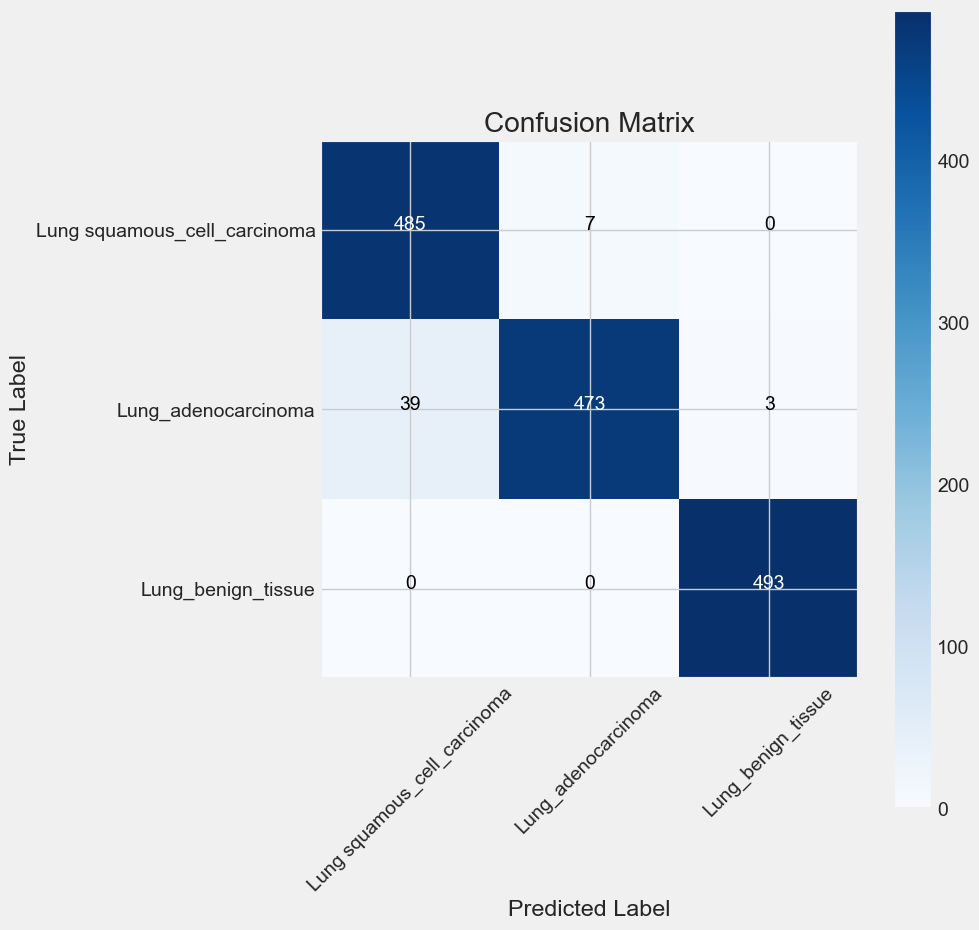

In [17]:
# get predictions
y_pred = get_pred(cnn_model, test_gen)

# plot the confusion matrix
plot_confusion_matrix(test_gen, y_pred)

# **EfficientNetB1**

In [18]:
# get the pre-trained model (EfficientNetB1)
base_model = EfficientNetB1(weights='imagenet', include_top=False, input_shape = img_shape, pooling= None)

# fine-tune EfficientNetB1 (Adding some custom layers on top)
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = BatchNormalization()(x)
x = dense_block(128, 0.5)(x)
x = dense_block(32, 0.2)(x)
predictions = Dense(class_counts, activation = "softmax")(x)    # output layer with softmax activation

# the model
EfficientNetB1_model = Model(inputs = base_model.input, outputs = predictions)

In [19]:
EfficientNetB1_model.compile(optimizer=Adamax(learning_rate=0.0001), loss='categorical_crossentropy', metrics=['accuracy'])

EfficientNetB1_model.summary()

Model: "functional_21"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_8       │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ rescaling           │ (None, 224, 224,  │          0 │ input_layer_8[0]… │
│ (Rescaling)         │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ normalization       │ (None, 224, 224,  │          7 │ rescaling[0][0]   │
│ (Normalization)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ rescaling_1         │ (None, 224, 224,  │          0 │ normalization[0]… │
│ (Rescaling)         │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_conv_pad       │ (None, 225, 225,  │          0 │ rescaling_1[0][0] │
│ (ZeroPadding2D)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_conv (Conv2D)  │ (None, 112, 112,  │        864 │ stem_conv_pad[0]… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_bn             │ (None, 112, 112,  │        128 │ stem_conv[0][0]   │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_activation     │ (None, 112, 112,  │          0 │ stem_bn[0][0]     │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_dwconv      │ (None, 112, 112,  │        288 │ stem_activation[… │
│ (DepthwiseConv2D)   │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_bn          │ (None, 112, 112,  │        128 │ block1a_dwconv[0… │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_activation  │ (None, 112, 112,  │          0 │ block1a_bn[0][0]  │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_squeeze  │ (None, 32)        │          0 │ block1a_activati… │
│ (GlobalAveragePool… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_reshape  │ (None, 1, 1, 32)  │          0 │ block1a_se_squee… │
│ (Reshape)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_reduce   │ (None, 1, 1, 8)   │        264 │ block1a_se_resha… │
│ (Conv2D)            │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_expand   │ (None, 1, 1, 32)  │        288 │ block1a_se_reduc… │
│ (Conv2D)            │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_excite   │ (None, 112, 112,  │          0 │ block1a_activati… │
│ (Multiply)          │ 32)               │            │ block1a_se_expan… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_project_co… │ (None, 112, 112,  │        512 │ block1a_se_excit

 Total params: 6,749,194 (25.75 MB)

 Trainable params: 6,684,259 (25.50 MB)

 Non-trainable params: 64,935 (253.66 KB)

In [20]:
# train the model
epochs = 11 # number of all epochs in training

EfficientNetB1_history = EfficientNetB1_model.fit(train_gen, epochs= epochs, verbose= 1, validation_data= valid_gen, shuffle= False)

Epoch 1/11
375/375 ━━━━━━━━━━━━━━━━━━━━ 1324s 3s/step - accuracy: 0.6418 - loss: 0.8467 - val_accuracy: 0.3200 - val_loss: 1.4063
Epoch 2/11
375/375 ━━━━━━━━━━━━━━━━━━━━ 1278s 3s/step - accuracy: 0.8892 - loss: 0.3063 - val_accuracy: 0.8240 - val_loss: 0.4395
Epoch 3/11
375/375 ━━━━━━━━━━━━━━━━━━━━ 1287s 3s/step - accuracy: 0.9239 - loss: 0.2230 - val_accuracy: 0.3367 - val_loss: 2.8918
Epoch 4/11
375/375 ━━━━━━━━━━━━━━━━━━━━ 1286s 3s/step - accuracy: 0.9542 - loss: 0.1529 - val_accuracy: 0.3340 - val_loss: 2.9179
Epoch 5/11
375/375 ━━━━━━━━━━━━━━━━━━━━ 1275s 3s/step - accuracy: 0.9641 - loss: 0.1266 - val_accuracy: 0.3413 - val_loss: 2.7596
Epoch 6/11
375/375 ━━━━━━━━━━━━━━━━━━━━ 1271s 3s/step - accuracy: 0.9705 - loss: 0.0991 - val_accuracy: 0.9260 - val_loss: 0.2092
Epoch 7/11
375/375 ━━━━━━━━━━━━━━━━━━━━ 1275s 3s/step - accuracy: 0.9788 - loss: 0.0763 - val_accuracy: 0.4960 - val_loss: 1.4091
Epoch 8/11
375/375 ━━━━━━━━━━━━━━━━━━━━ 1277s 3s/step - accuracy: 0.9847 - loss: 0.0621 - 

**Display model performance**

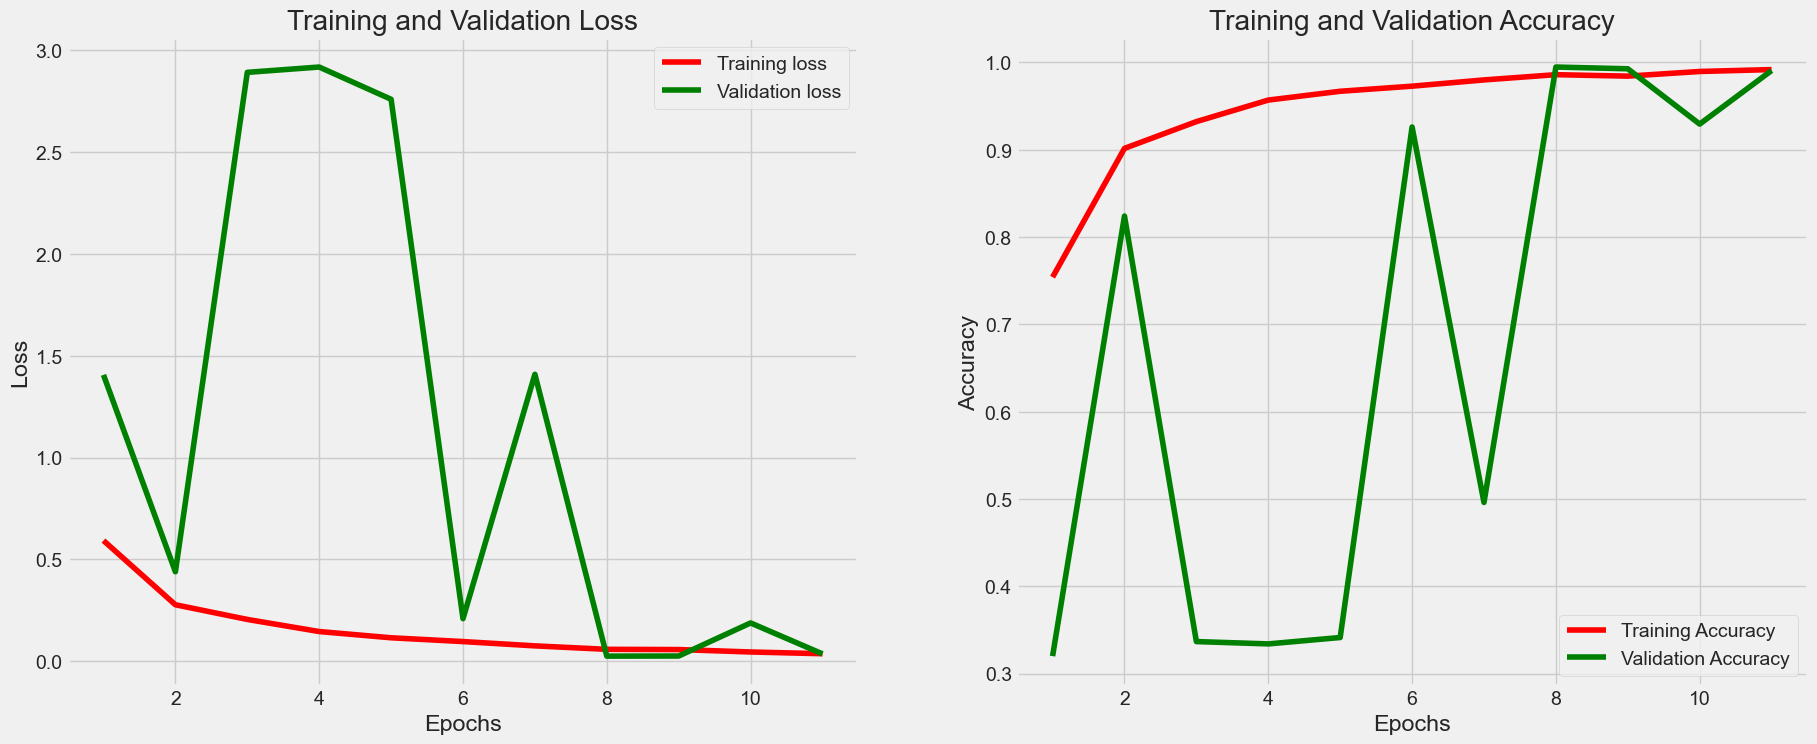

In [21]:
# Display model performance
model_performance(EfficientNetB1_history, epochs)

**Evaluate the model**

In [22]:
# Model evaluation
model_evaluation(EfficientNetB1_model)

375/375 ━━━━━━━━━━━━━━━━━━━━ 229s 612ms/step - accuracy: 0.9970 - loss: 0.0191
47/47 ━━━━━━━━━━━━━━━━━━━━ 28s 603ms/step - accuracy: 0.9913 - loss: 0.0377
47/47 ━━━━━━━━━━━━━━━━━━━━ 29s 613ms/step - accuracy: 0.9871 - loss: 0.0374
Train Loss:  0.02057487703859806
Train Accuracy:  0.9958333373069763
--------------------
Validation Loss:  0.03625547140836716
Validation Accuracy:  0.9906666874885559
--------------------
Test Loss:  0.030890149995684624
Test Accuracy:  0.9906666874885559


**Get predictions and display the confusion matrix**

47/47 ━━━━━━━━━━━━━━━━━━━━ 34s 662ms/step


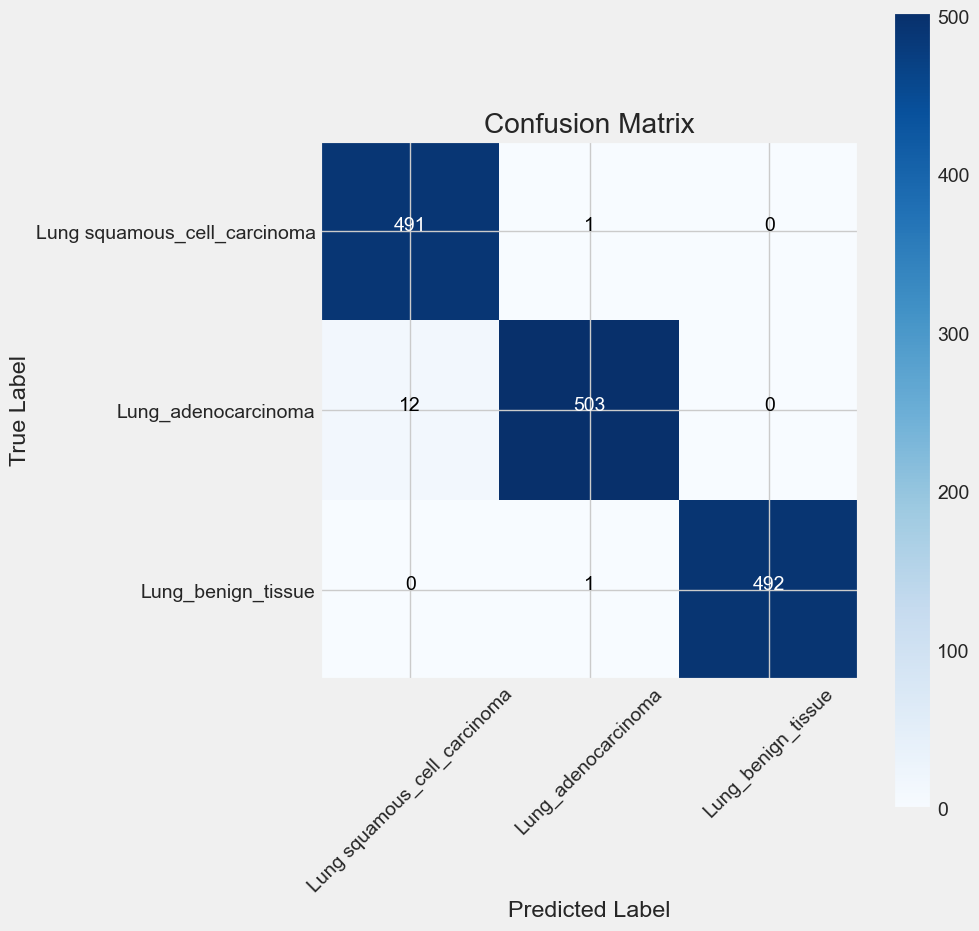

In [23]:
# get predictions
y_pred = get_pred(EfficientNetB1_model, test_gen)

# plot the confusion matrix
plot_confusion_matrix(test_gen, y_pred)

In [24]:
# Save the model in .h5 format (legacy format)
cnn_model.save('cnn_lung_cancer2_model.h5')

In [25]:
# Save the model in .h5 format (legacy format)
EfficientNetB1_model.save('efficientnetb1_lung_cancer_model.h5')

In [26]:
import tensorflow as tf

# Load the model using TensorFlow
model = tf.keras.models.load_model("efficientnetb1_lung_cancer_model.h5")

# Save it in the new Keras 3 format
model.save("efficientnetb1_lung_cancer_model.keras", save_format="keras")